In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import seaborn as sns
import ruptures as rpt
from scipy.signal import find_peaks
from sklearn.decomposition import PCA as SKPCA


## Generate First DF

In [3]:
def convertDF(path): 
    '''converting a dataframe to a new datafrom with float, 5 decimal places and '''

    # reading in file, and skipping top row
    df = pd.read_csv(path, skiprows=1)

    print(df)

    # defining the titles of the rows
    body_loc = df.columns.tolist()

    # creating new empty dataframe
    df_new = pd.DataFrame()


    for part in body_loc:
        if part == 'bodyparts' in part:
            continue
        else:
            df_new[part] = pd.to_numeric(df[part].iloc[1:], errors='coerce').dropna().round(5).astype(float)


    # Copy your DataFrame
    cleaned_df = df_new.copy()

    # Get base marker names by stripping '.1' and '.2'
    marker_names = {'PalmBase', 'MCP1', 'MCP2', 'MCP3', 'MCP4', 'MCP5', 'fTip1', 'fTip2', 'fTip3', 'fTip4', 'fTip5', 'MidForeArm', 'Elbow'}

    print(marker_names)

    for marker in marker_names:
        x_col = marker
        y_col = marker + '.1'
        l_col = marker + '.2'

        # Phase 1: Find first row where likelihood >= 0.8
        # Boolean mask for where likelihood >= 0.95
        high_likelihood = cleaned_df[l_col] >= 0.95

        # Find where two consecutive values are both True
        consecutive_valid = high_likelihood & high_likelihood.shift(-1, fill_value=False)

        # Get the index of the first such occurrence
        first_valid_idx = consecutive_valid[consecutive_valid].index.min()

        # Remove all rows before first high-confidence point
        cleaned_df.loc[:first_valid_idx - 1, [l_col]] = np.nan

        # Phase 2: Set x/y to NaN where likelihood < 0.95
        low_conf_mask = cleaned_df[l_col] < 0.95
        cleaned_df.loc[low_conf_mask, [x_col, y_col]] = np.nan

        # Interpolate x and y
        cleaned_df[[x_col, y_col]] = cleaned_df[[x_col, y_col]].interpolate(method='linear', limit_direction='both')

        # Phase 3: Set x and y to 0 where likelihood is NaN
        nan_likelihood_mask = cleaned_df[l_col].isna()
        cleaned_df.loc[nan_likelihood_mask, [x_col, y_col]] = 0


    # (Optional) Reset index or drop NaNs if needed
    # cleaned_df = cleaned_df.dropna(subset=marker_names)  # if you want to drop completely bad rows

    # cleaned_df now has cleaned x/y data based on per-marker likelihoods

    cleaned_df


    return cleaned_df

# defining my path to pt one
sub = Path(r'X:\RadcliffeE\for_MorganHampton_BoettcherScholar\Subject Case Data\IO_03_09_2023_RSTN_subject1\Processed DLC\csv folder')

# list of all the videos for this specific patient (c1s is missing for this patient)
dbs_loc = ['b1f', 'b1s', 'b2f', 'b2s', 'b3f', 'b3s', 'c2f', 'c1s', 'c2s', 'c3f', 'c3s', 't1f', 't1s', 't2f', 't2s', 't3f', 't3s']

# place to store all the df
dataframes = {}

files = list(sub.iterdir())

# iterating over each file for pt 1 and converting the df to floats and cleaning up the data
for file, label in zip(sub.iterdir(), dbs_loc):
    dataframes[label] = convertDF(file)
    print(f"{label} loaded from {file.name}")

     bodyparts            PalmBase         PalmBase.1           PalmBase.2  \
0       coords                   x                  y           likelihood   
1            0   427.6842041015625  525.0423583984375  0.14588609337806702   
2            1   427.5551452636719  525.5269775390625   0.1911419928073883   
3            2   428.8374938964844  525.0931396484375  0.17686539888381958   
4            3   427.6429138183594  525.9227905273438   0.1331915706396103   
...        ...                 ...                ...                  ...   
4254      4253   409.2789306640625  529.5111694335938  0.20932647585868835   
4255      4254        410.21484375  528.4324951171875   0.1871751844882965   
4256      4255  409.49407958984375   529.206298828125  0.22666633129119873   
4257      4256   409.3077697753906  529.0945434570312  0.23516501486301422   
4258      4257   409.7013854980469  529.1215209960938   0.1964298039674759   

                    MCP1             MCP1.1               MCP1.

## PCA functions

In [4]:
def run_PCA(X, indices, view, mov, n_components=None):
    '''Calculates PCA for one camera view and one probe position'''

    # 1. Takes into consideration if there are indices or not (helpful for when looking at specific movement)
    if indices is not None:
        X_subset = X.iloc[indices[0]:indices[1]+1]
    else:
        X_subset = X

    # 2. Drop columns containing '.2' --> dropping likelihood rows
    df = X_subset.loc[:, ~X_subset.columns.str.contains(r'\.2')]

    # 3. Remove constant columns --> gets rid of runs that were unsuccessful 
    stds = df.std(axis=0)
    df = df.loc[:, stds != 0]

    # 4. Standardize the data --> standardize mean to 0 and std to 1 (suggested from geeks for geeks)
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(df)

    # 5. Apply PCA
    pca = SKPCA(n_components=n_components)
    X_pca = pca.fit_transform(X_standardized)

    # 6. Output
    explained_variance_ratio = pca.explained_variance_ratio_
    explained_variance = pca.explained_variance_
    pca_components = pca.components_ # direction (vectors) the define the PCs in the original feature space pca_components[0] are the scores in regards to PCA1



    return X_pca, explained_variance_ratio, explained_variance, pca_components


def trim_initial_zeros(df):
    """
    Trims the DataFrame by removing rows at the beginning where ANY column is 0.
    Once all columns have non-zero values, keeps everything from that row on.
    Necessary because rows were set to 0 when filtering likelihood
    """
    mask = (df != 0).any(axis=1)
    first_valid_index = mask.idxmax()  # first row where any column is non-zero
    return df.loc[first_valid_index:].reset_index(drop=True)

In [5]:
# creates empty lists for all view scores and one for only the PCA1 scores
rows_front = []
rows_side = []
pca1_rows = []
pca2_rows = []
explained_var_rows = []
top5_pc1_rows = []

# iterates over each view and depth (b1s, b1f, b2s......)
# creates new df (pca1_df) with all the scores from PC1 in regards to each movement
for i in dataframes:
    base = i    # like 'b1f', 't2s'
    mov = 'all'  # looking at full video, not yet sectioning out the movements
    df = dataframes[base]  # setting df to qual the data from b1f for example

    # Trim zeros from beginning of view
    view_trimmed = trim_initial_zeros(df)

    # Run PCA on trimmed data
    X_pca, explained_variance_ratio, explained_variance_raw, components = run_PCA(view_trimmed, None, base, mov)

    # Extract original columns used in PCA (excluding dropped/constant)
    used_columns = view_trimmed.loc[:, ~view_trimmed.columns.str.contains(r'\.2')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()



    print(f' For {base} the variance for PC1 is {explained_variance_ratio[0]} and PC2 is {explained_variance_ratio[1]}')

    #Storing each into a new dataframe to later pull from 
    # Extract depth and view info from 'base'
    depth = base[:-1]  # e.g. 'b1f' -> 'b1'
    view_type = 'front' if base.endswith('f') else 'side'

    # PC1 and PC2 component weights (loadings)
    pc1 = components[0]
    pc2 = components[1]

    # Create a dict for this depth/view row (PC1)
    row_pc1 = {
        "depth": depth,
        "view": view_type,
        "component": "PC1"
    }

    # Create a dict for PC2
    row_pc2 = {
        "depth": depth,
        "view": view_type,
        "component": "PC2"
    }


    # Add feature component weights to both PC1 and PC2 rows
    for feat, weight1, weight2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = weight1
        row_pc2[feat] = weight2

    # Append both rows
    pca1_rows.append(row_pc1)
    pca2_rows.append(row_pc2)

    explained_var_rows.append({
        "depth": depth,
        "view": view_type,
        "PC1_var": explained_variance_ratio[0],
        "PC2_var": explained_variance_ratio[1],
    })


    # Create list of (feature, weight) for PC1
    feature_contributions = list(zip(final_cols, pc1))

    # Sort by absolute contribution descending
    feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)

    # Take top 5 contributors
    top5 = feature_contributions[:5]

    # Save top 5 contributors for PC1
    top5_dict = {
        "depth": depth,
        "view": view_type
    }
    for idx, (feat, weight) in enumerate(top5):
        top5_dict[f"feature_{idx+1}"] = feat
        top5_dict[f"weight_{idx+1}"] = weight
    top5_pc1_rows.append(top5_dict)

    # At the end of the loop (outside the for i in dataframes loop), convert lists to DataFrames:
    pca1_df = pd.DataFrame(pca1_rows)
    pca2_df = pd.DataFrame(pca2_rows)
    explained_df = pd.DataFrame(explained_var_rows)
    top5_df = pd.DataFrame(top5_pc1_rows)


top5_df

 For b1f the variance for PC1 is 0.8490056828855066 and PC2 is 0.11427741214688264
 For b1s the variance for PC1 is 0.80254613188896 and PC2 is 0.06288629151670007
 For b2f the variance for PC1 is 0.6429296155127452 and PC2 is 0.20477277967465926
 For b2s the variance for PC1 is 0.8005171707879268 and PC2 is 0.07955680656633123
 For b3f the variance for PC1 is 0.38024775816758494 and PC2 is 0.3378985353547184
 For b3s the variance for PC1 is 0.7782193058994018 and PC2 is 0.07204749631714916
 For c2f the variance for PC1 is 0.6177304913829479 and PC2 is 0.155872503833324
 For c1s the variance for PC1 is 0.781193534642181 and PC2 is 0.1856461978482146
 For c2s the variance for PC1 is 0.5977167834641768 and PC2 is 0.16376948748583706
 For c3f the variance for PC1 is 0.7764586381374889 and PC2 is 0.17826899888620992
 For c3s the variance for PC1 is 0.5865596552698271 and PC2 is 0.15076350421147966
 For t1f the variance for PC1 is 0.5584973423884028 and PC2 is 0.13298145798115205
 For t1s t

depth   view     feature_1  weight_1      feature_2  weight_2   feature_3  \
0     b1  front          MCP4  0.204081           MCP3  0.204048        MCP2   
1     b1   side          MCP2  0.208490       PalmBase  0.208021        MCP1   
2     b2  front          MCP5  0.227880          fTip1  0.226984  PalmBase.1   
3     b2   side          MCP3  0.204732           MCP2  0.204459        MCP4   
4     b3  front        MCP5.1  0.272424        fTip4.1  0.266012     fTip3.1   
5     b3   side      PalmBase  0.208793           MCP1  0.207411        MCP3   
6     c2  front          MCP3  0.223385           MCP2  0.222880    PalmBase   
7     c1   side  MidForeArm.1  0.210001     PalmBase.1  0.208405      MCP5.1   
8     c2   side          MCP3  0.238698     MidForeArm  0.237315    PalmBase   
9     c3  front  MidForeArm.1  0.209709     PalmBase.1  0.209399        MCP5   
10    c3   side    MidForeArm  0.243528          fTip5  0.241040    PalmBase   
11    t1  front        MCP5.1  0.233699         MCP4.1  0.233577      MCP3.1   
12    t1   side          MCP2  0.216121         MCP2.1  0.215871      MCP1.1   
13    t2  front   MidUpperArm  0.707107  MidUpperArm.1  0.707107         NaN   
14    t2   side         fTip5  0.245662          fTip4  0.245646        MCP3   
15    t3  front        MCP5.1  0.214686     PalmBase.1  0.213044        MCP5   
16    t3   side      PalmBase  0.205615     PalmBase.1  0.204952        MCP2   

    weight_3   feature_4  weight_4   feature_5  weight_5  
0   0.203466        MCP1  0.203392        MCP5  0.203381  
1   0.207667       fTip1  0.207569  PalmBase.1  0.207513  
2   0.226743        MCP1  0.225806        MCP4  0.225499  
3   0.204232    PalmBase  0.203507  PalmBase.1  0.203313  
4   0.265761     fTip2.1  0.262886     fTip1.1  0.262356  
5   0.206972       fTip1  0.206772        MCP2  0.206414  
6   0.221596      MCP3.1  0.221500        MCP4  0.221071  
7   0.207287        MCP4  0.206987        MCP3  0.206668  
8   0.235782       fTip5  0.233182       fTip4  0.232548  
9   0.208629        MCP4  0.207357        MCP1  0.207040  
10  0.240575       fTip4  0.240157        MCP5  0.239837  
11  0.232492  MidForeArm  0.231601        MCP5  0.226939  
12  0.210206       fTip2  0.207594     fTip1.1  0.205937  
13       NaN         NaN       NaN         NaN       NaN  
14  0.245611      MCP3.1  0.245289     fTip5.1  0.245026  
15  0.211776      MCP1.1  0.211766        MCP4  0.211421  
16  0.204582        MCP3  0.204193        MCP1  0.204157

In [32]:
# Initialize empty lists before loop
pca1_rows = []
pca2_rows = []
explained_var_rows = []
top5_pc1_rows = []
top5_pc2_rows = []

for base in dataframes:
    mov = 'all'  # example movement label
    df = dataframes[base]

    # Trim zeros from beginning of view
    view_trimmed = trim_initial_zeros(df)

    # Extract original columns used in PCA (excluding dropped/constant)
    used_columns = view_trimmed.loc[:, ~view_trimmed.columns.str.contains(r'\.2')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()

    # Run PCA on trimmed data
    X_pca, explained_variance_ratio, explained_variance_raw, components = run_PCA(view_trimmed, None, base, mov)

    print(f'For {base} the variance for PC1 is {explained_variance_ratio[0]:.4f} and PC2 is {explained_variance_ratio[1]:.4f}')

    # Extract depth and view info from 'base'
    depth = base[:-1]  # e.g. 'b1f' -> 'b1'
    view_type = 'front' if base.endswith('f') else 'side'

    # PC1 and PC2 component weights (loadings)
    pc1 = components[0]
    pc2 = components[1]

    # Create dicts for PC1 and PC2 rows
    row_pc1 = {
        "depth": depth,
        "view": view_type,
        "component": "PC1"
    }
    row_pc2 = {
        "depth": depth,
        "view": view_type,
        "component": "PC2"
    }

    # Add feature component weights to both PC1 and PC2 rows
    for feat, weight1, weight2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = weight1
        row_pc2[feat] = weight2

    # Append rows to respective lists
    pca1_rows.append(row_pc1)
    pca2_rows.append(row_pc2)

    # Save explained variance for PC1 and PC2
    explained_var_rows.append({
        "depth": depth,
        "view": view_type,
        "PC1_var": explained_variance_ratio[0],
        "PC2_var": explained_variance_ratio[1],
    })

    # Top 5 contributors for PC1
    feature_contributions_pc1 = list(zip(final_cols, pc1))
    feature_contributions_pc1.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc1 = feature_contributions_pc1[:5]

    top5_pc1_dict = {
        "depth": depth,
        "view": view_type,
        "component": "PC1"
    }
    for idx, (feat, weight) in enumerate(top5_pc1):
        top5_pc1_dict[f"feature_{idx+1}"] = feat
        top5_pc1_dict[f"weight_{idx+1}"] = weight
    top5_pc1_rows.append(top5_pc1_dict)

    # Top 5 contributors for PC2
    feature_contributions_pc2 = list(zip(final_cols, pc2))
    feature_contributions_pc2.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc2 = feature_contributions_pc2[:5]

    top5_pc2_dict = {
        "depth": depth,
        "view": view_type,
        "component": "PC2"
    }
    for idx, (feat, weight) in enumerate(top5_pc2):
        top5_pc2_dict[f"feature_{idx+1}"] = feat
        top5_pc2_dict[f"weight_{idx+1}"] = weight
    top5_pc2_rows.append(top5_pc2_dict)

# Create DataFrames after loop
pca1_df = pd.DataFrame(pca1_rows)
pca2_df = pd.DataFrame(pca2_rows)
explained_df = pd.DataFrame(explained_var_rows)
top5_pc1_df = pd.DataFrame(top5_pc1_rows)
top5_pc2_df = pd.DataFrame(top5_pc2_rows)

print(top5_pc1_df)
print(top5_pc2_df)


For b1f the variance for PC1 is 0.8490 and PC2 is 0.1143
For b1s the variance for PC1 is 0.8025 and PC2 is 0.0629
For b2f the variance for PC1 is 0.6429 and PC2 is 0.2048
For b2s the variance for PC1 is 0.8005 and PC2 is 0.0796
For b3f the variance for PC1 is 0.3802 and PC2 is 0.3379
For b3s the variance for PC1 is 0.7782 and PC2 is 0.0720
For c2f the variance for PC1 is 0.6177 and PC2 is 0.1559
For c1s the variance for PC1 is 0.7812 and PC2 is 0.1856
For c2s the variance for PC1 is 0.5977 and PC2 is 0.1638
For c3f the variance for PC1 is 0.7765 and PC2 is 0.1783
For c3s the variance for PC1 is 0.5866 and PC2 is 0.1508
For t1f the variance for PC1 is 0.5585 and PC2 is 0.1330
For t1s the variance for PC1 is 0.7355 and PC2 is 0.1137
For t2f the variance for PC1 is 0.6510 and PC2 is 0.3490
For t2s the variance for PC1 is 0.7656 and PC2 is 0.0798
For t3f the variance for PC1 is 0.7283 and PC2 is 0.1804
For t3s the variance for PC1 is 0.7800 and PC2 is 0.0830
   depth   view component     f

Processing depth=b1, view=front


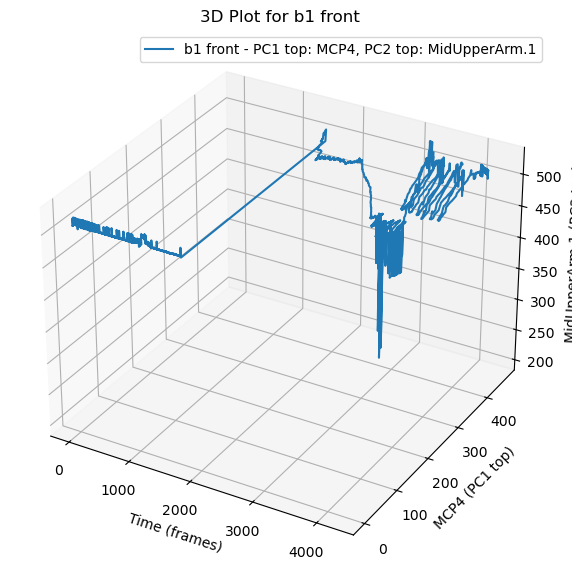

Processing depth=b1, view=side


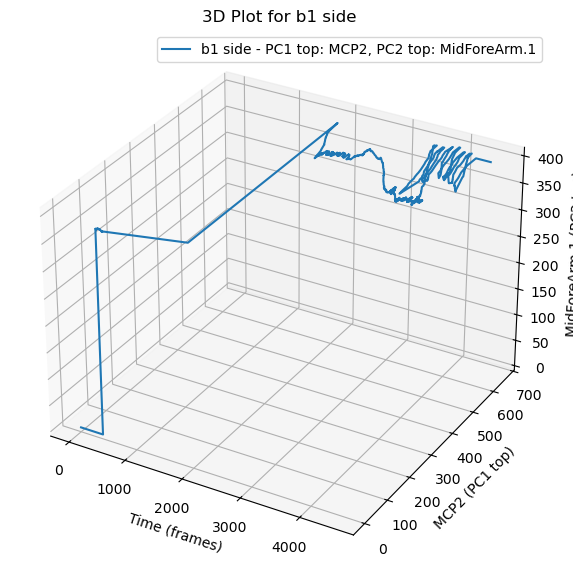

Processing depth=b2, view=front


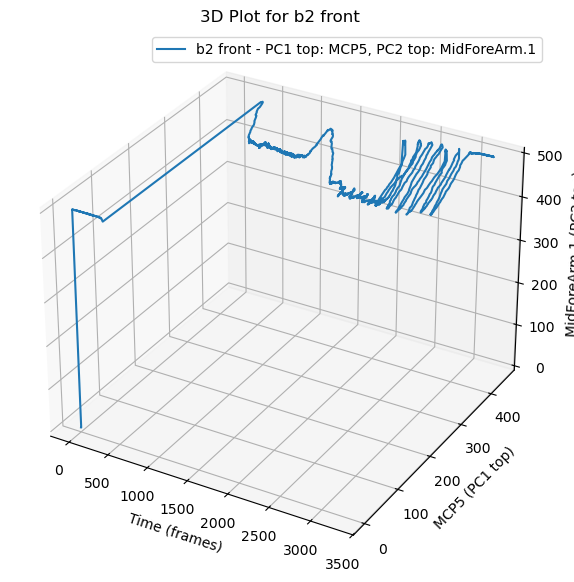

Processing depth=b2, view=side


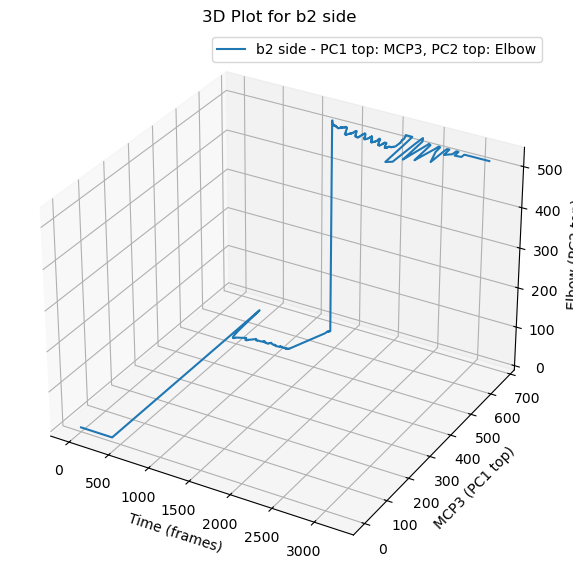

Processing depth=b3, view=front


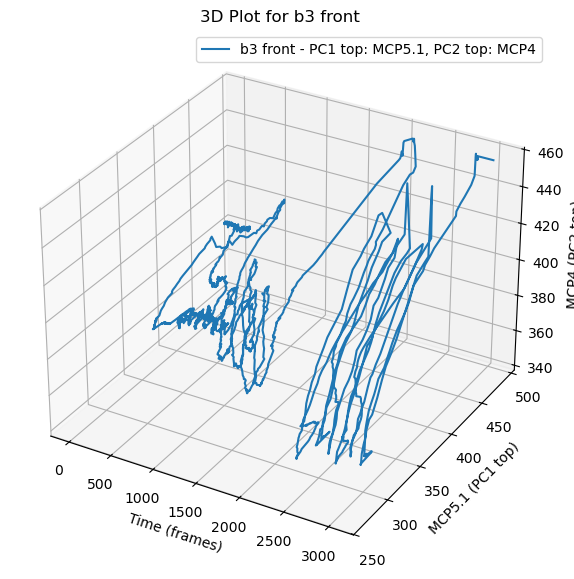

Processing depth=b3, view=side


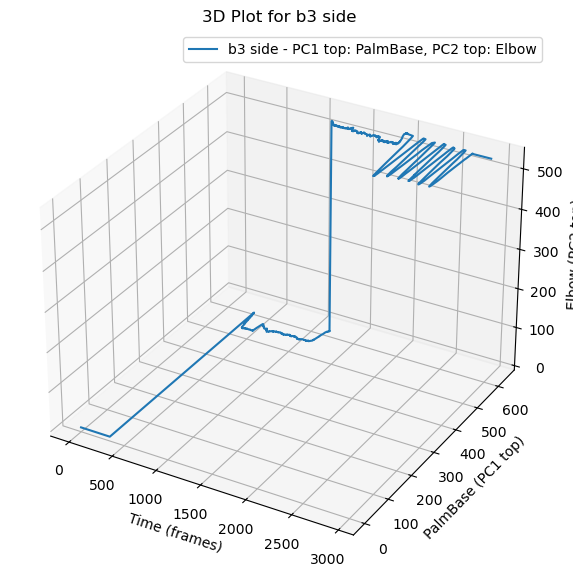

Processing depth=c2, view=front


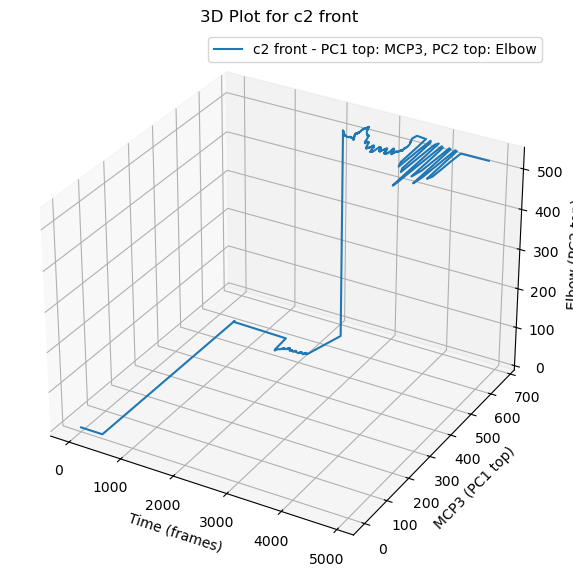

Processing depth=c2, view=side


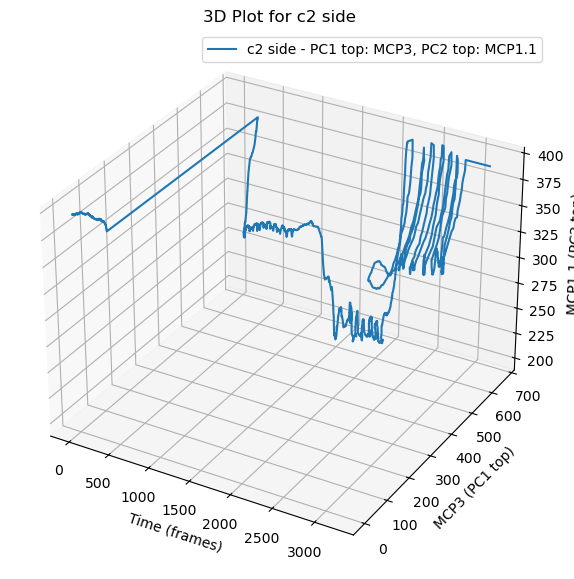

Processing depth=c1, view=front
Skipping c1 front - missing top features
Processing depth=c1, view=side


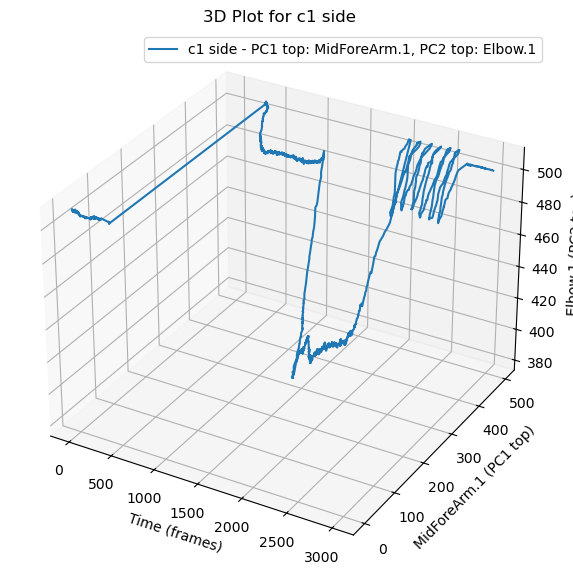

Processing depth=c3, view=front


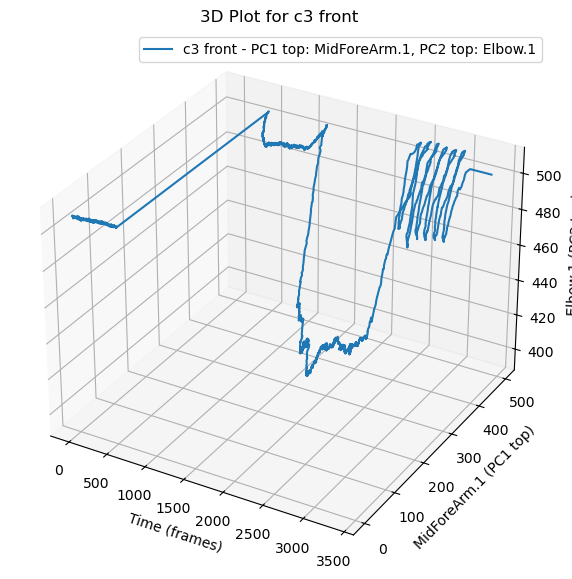

Processing depth=c3, view=side


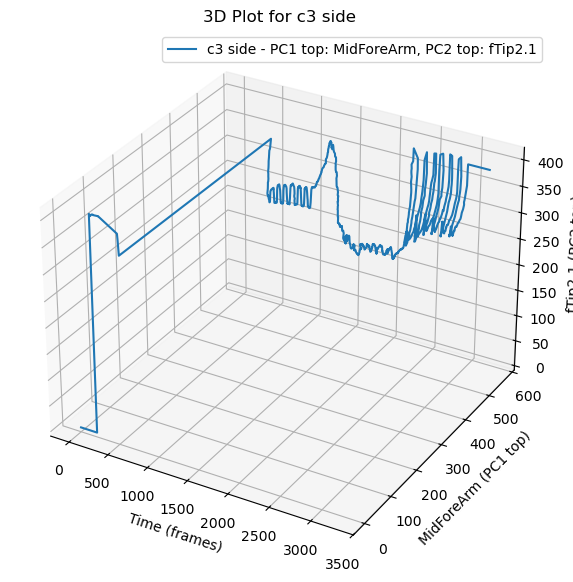

Processing depth=t1, view=front


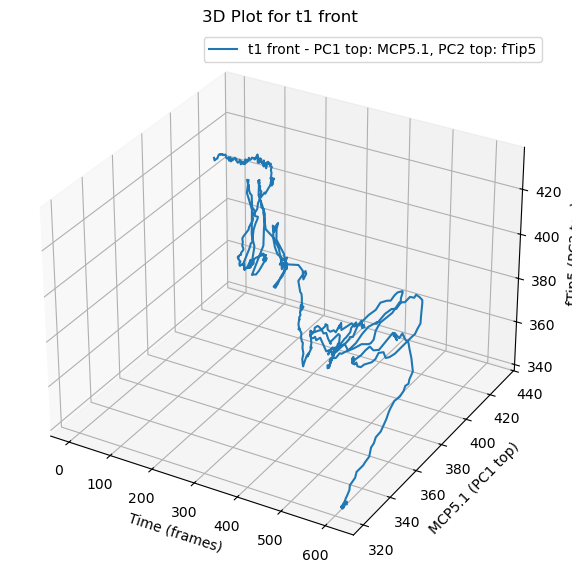

Processing depth=t1, view=side


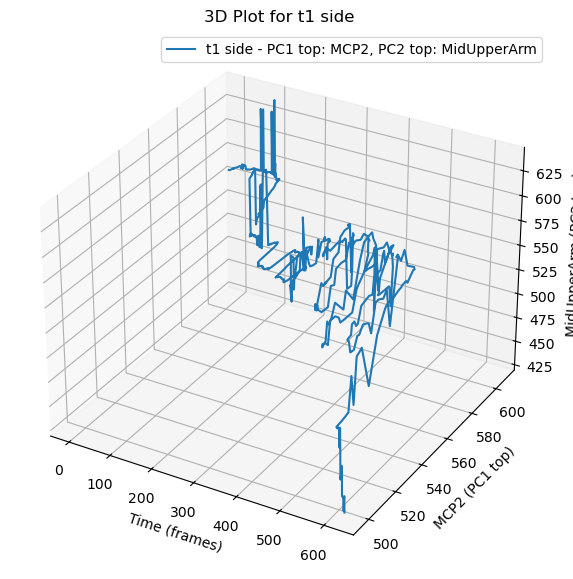

Processing depth=t2, view=front


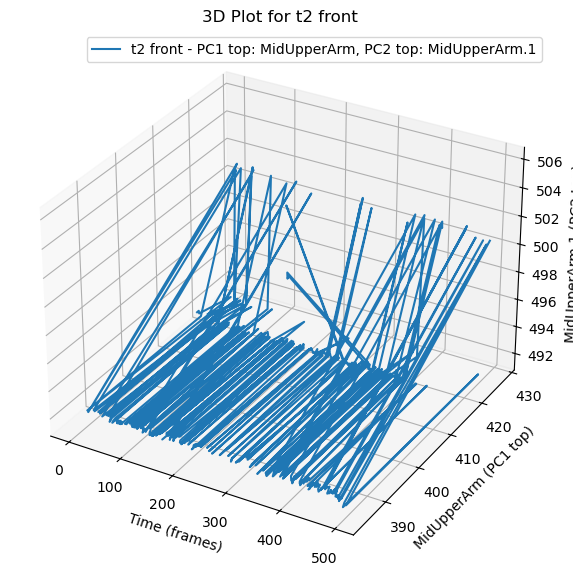

Processing depth=t2, view=side


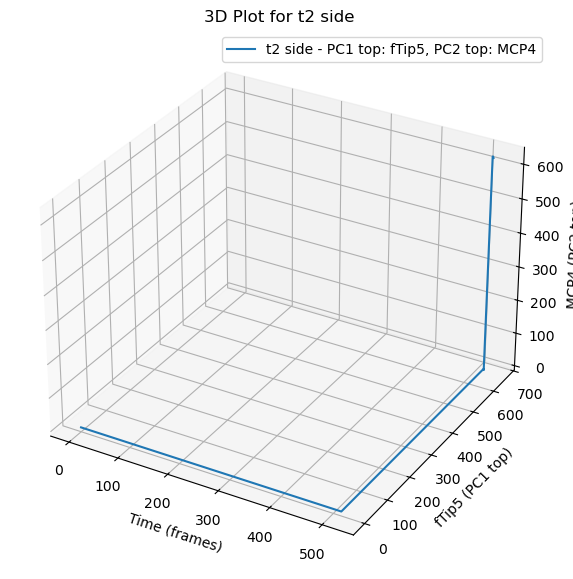

Processing depth=t3, view=front


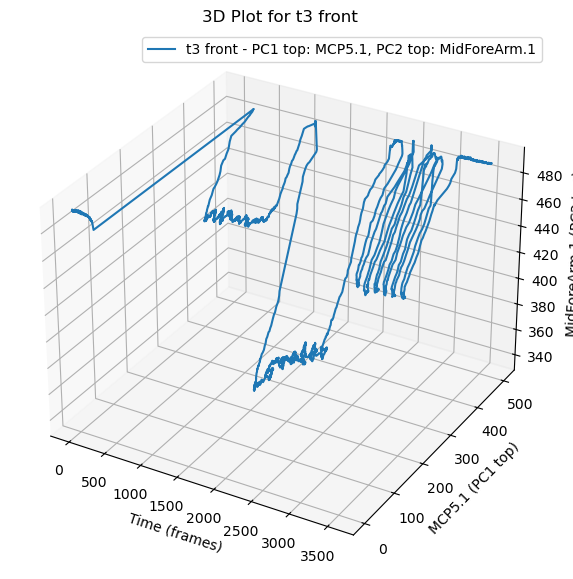

Processing depth=t3, view=side


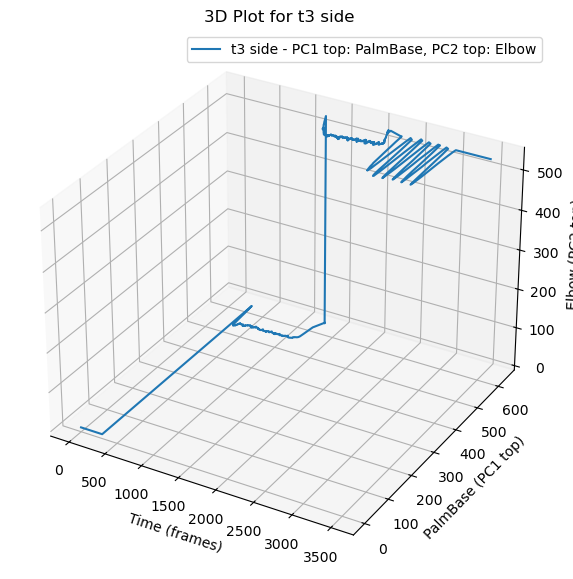

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necessary for 3D plotting

# Helper: get top feature for PC from top5_df DataFrame (which you created above)
def get_top_feature(top5_df, depth, view, component='PC1'):
    subset = top5_df[(top5_df['depth'] == depth) & (top5_df['view'] == view) & (top5_df['component'] == component)]
    if subset.empty:
        return None
    return subset.iloc[0]['feature_1']  # the top feature is in feature_1 column

# Loop through unique depths and views from pca1_df or explained_df
depths = explained_df['depth'].unique()
views = explained_df['view'].unique()

for depth in depths:
    for view in views:
        print(f"Processing depth={depth}, view={view}")

        # Get top PC1 and PC2 features
        top_feature_pc1 = get_top_feature(top5_pc1_df, depth, view, 'PC1')
        top_feature_pc2 = get_top_feature(top5_pc2_df, depth, view, 'PC2')

        if top_feature_pc1 is None or top_feature_pc2 is None:
            print(f"Skipping {depth} {view} - missing top features")
            continue

        # Construct dataframe key with view suffix
        df_key = depth + ('f' if view == 'front' else 's')
        if df_key not in dataframes:
            print(f"Data for {df_key} not found in dataframes.")
            continue

        df = dataframes[df_key]

        # Extract the data for the two top features and time index
        if top_feature_pc1 not in df.columns or top_feature_pc2 not in df.columns:
            print(f"Features {top_feature_pc1} or {top_feature_pc2} not found in dataframe columns for {df_key}")
            continue

        x = df[top_feature_pc1].to_numpy()
        y = df[top_feature_pc2].to_numpy()
        t = np.arange(len(x))  # use index as time; or df['time'] if you have a time column

        # Plot in 3D
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        ax.plot(t, x, y, label=f"{depth} {view} - PC1 top: {top_feature_pc1}, PC2 top: {top_feature_pc2}")

        ax.set_xlabel('Time (frames)')
        ax.set_ylabel(f'{top_feature_pc1} (PC1 top)')
        ax.set_zlabel(f'{top_feature_pc2} (PC2 top)')
        ax.set_title(f"3D Plot for {depth} {view}")

        ax.legend()
        plt.show()



Processing depth=b1, view=front


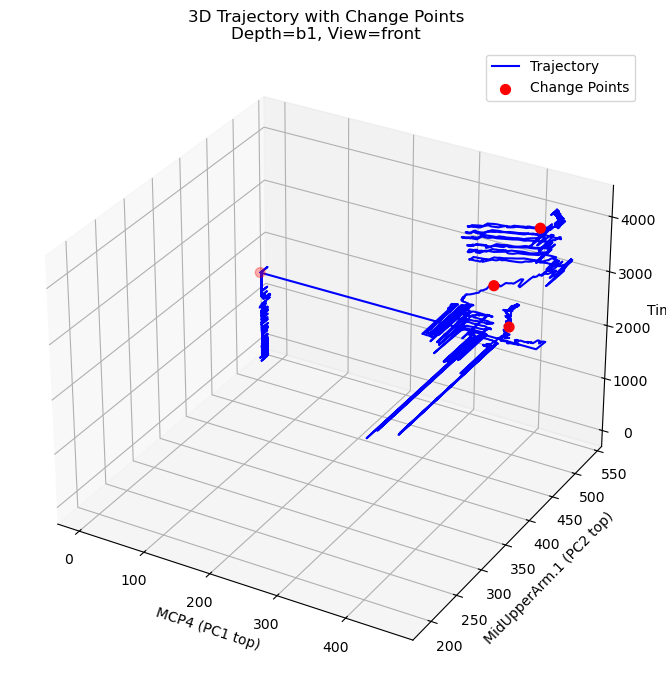

Change points (frame indices) for b1 front: [1730, 2495, 3220, 4000, 4258]

Processing depth=b1, view=side


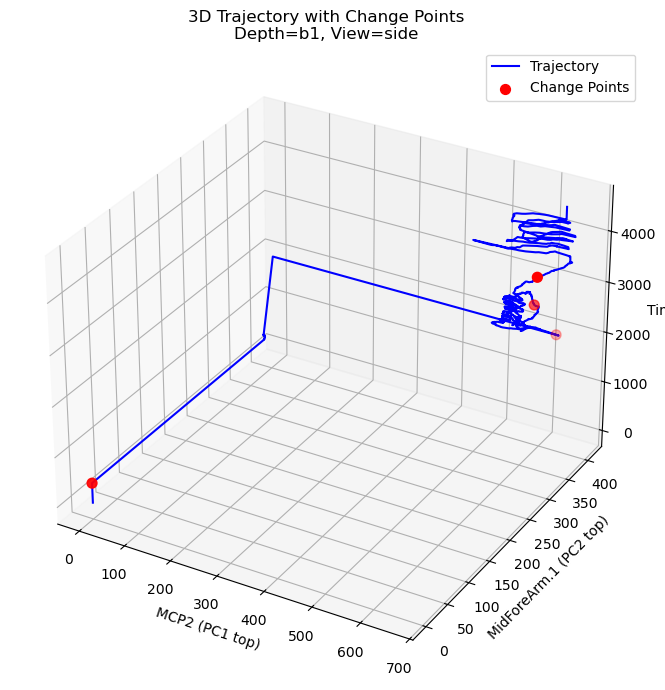

Change points (frame indices) for b1 side: [395, 1975, 2780, 3515, 4556]

Processing depth=b2, view=front


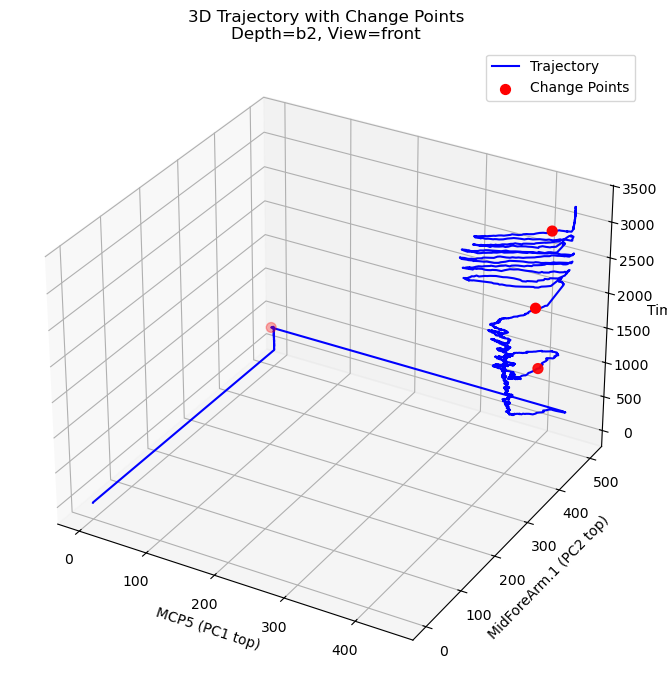

Change points (frame indices) for b2 front: [380, 1325, 2165, 2955, 3271]

Processing depth=b2, view=side


KeyboardInterrupt: 

In [10]:
import ruptures as rpt

# Parameters for ruptures
model = "rbf"
penalty_value = 35  # Adjust as needed

for depth in depths:
    for view in views:
        print(f"\nProcessing depth={depth}, view={view}")

        # Get top PC1 and PC2 features
        top_feature_pc1 = get_top_feature(top5_pc1_df, depth, view, 'PC1')
        top_feature_pc2 = get_top_feature(top5_pc2_df, depth, view, 'PC2')

        if top_feature_pc1 is None or top_feature_pc2 is None:
            print(f"Skipping {depth} {view} - missing top features")
            continue

        df_key = depth + ('f' if view == 'front' else 's')
        if df_key not in dataframes:
            print(f"Data for {df_key} not found in dataframes.")
            continue

        df = dataframes[df_key]

        if top_feature_pc1 not in df.columns or top_feature_pc2 not in df.columns:
            print(f"Features {top_feature_pc1} or {top_feature_pc2} not found in dataframe for {df_key}")
            continue

        # Extract data
        x = df[top_feature_pc1].to_numpy()
        y = df[top_feature_pc2].to_numpy()
        t = np.arange(len(x))

        # Stack for ruptures input
        signal = np.column_stack((x, y))  # shape (n_samples, 2)

        # Run RBF change point detection
        algo = rpt.Pelt(model=model).fit(signal)
        change_points = algo.predict(pen=penalty_value)


        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # 3D Line Plot of the Trajectory
        ax.plot(x, y, t, label='Trajectory', color='blue')

        # Plot change points as red scatter points
        cp_x = [x[i] for i in change_points[:-1]]  # exclude last if it's just the end
        cp_y = [y[i] for i in change_points[:-1]]
        cp_t = [t[i] for i in change_points[:-1]]
        ax.scatter(cp_x, cp_y, cp_t, color='red', s=50, label='Change Points')

        # Labels and title
        ax.set_xlabel(f"{top_feature_pc1} (PC1 top)")
        ax.set_ylabel(f"{top_feature_pc2} (PC2 top)")
        ax.set_zlabel("Time")
        ax.set_title(f"3D Trajectory with Change Points\nDepth={depth}, View={view}")
        ax.legend()

        plt.tight_layout()
        plt.show()




        # Print results
        print(f"Change points (frame indices) for {depth} {view}: {change_points}")



Processing depth=b1, view=front


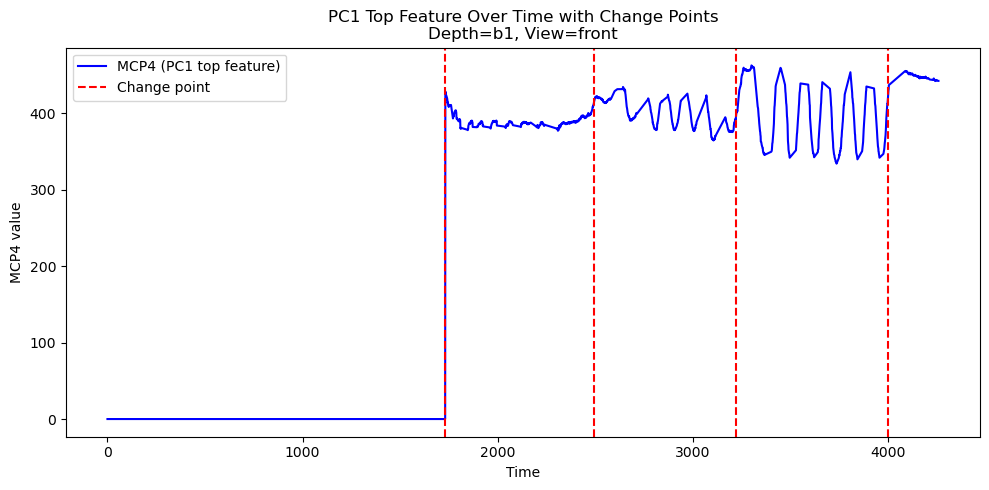

Change points (frame indices) for b1 front: [1730, 2495, 3220, 4000, 4258]

Processing depth=b1, view=side


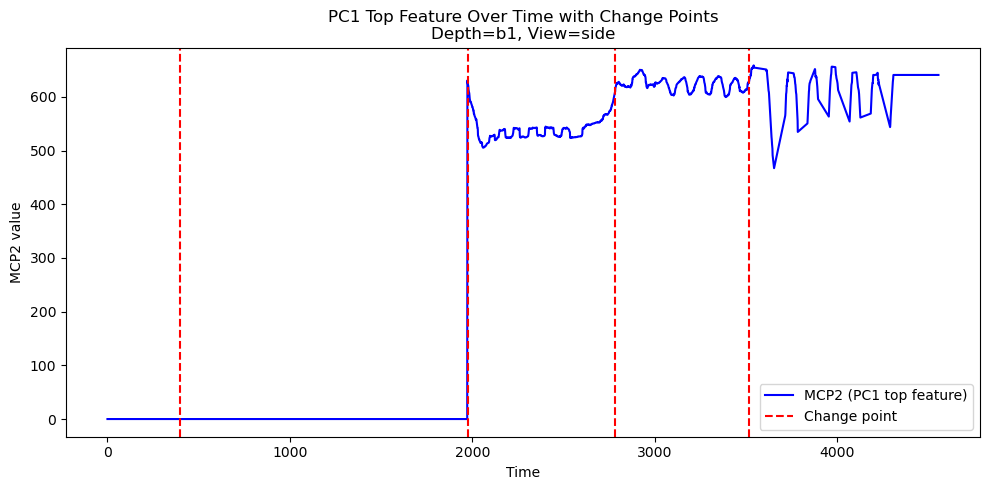

Change points (frame indices) for b1 side: [395, 1975, 2780, 3515, 4556]

Processing depth=b2, view=front


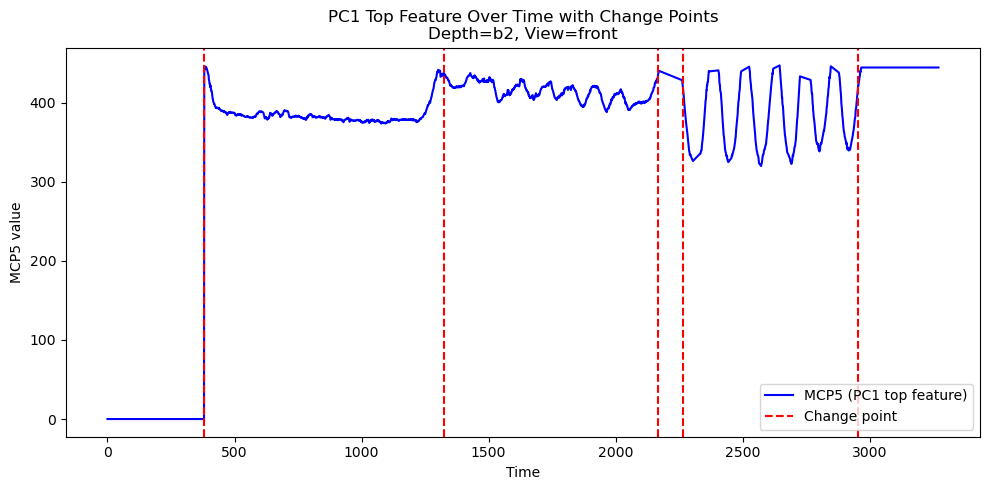

Change points (frame indices) for b2 front: [380, 1325, 2165, 2265, 2955, 3271]

Processing depth=b2, view=side


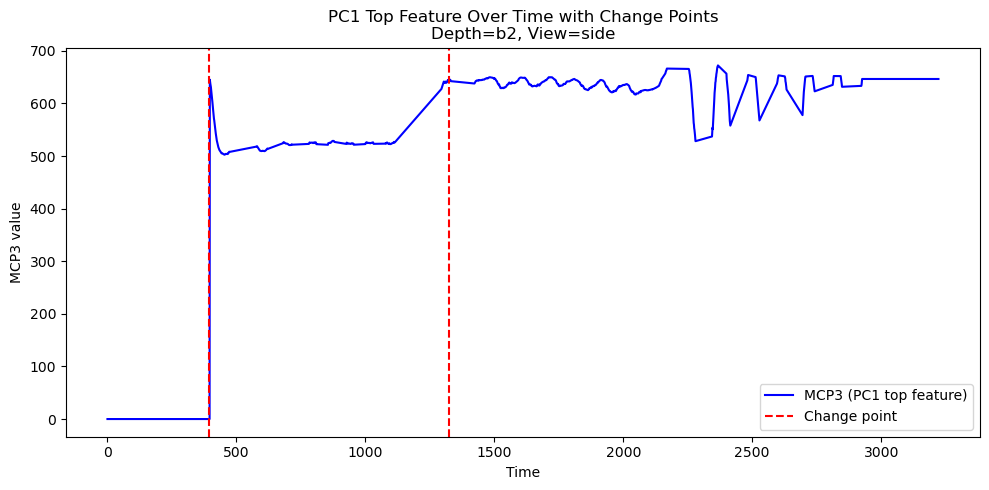

Change points (frame indices) for b2 side: [395, 1325, 3223]

Processing depth=b3, view=front


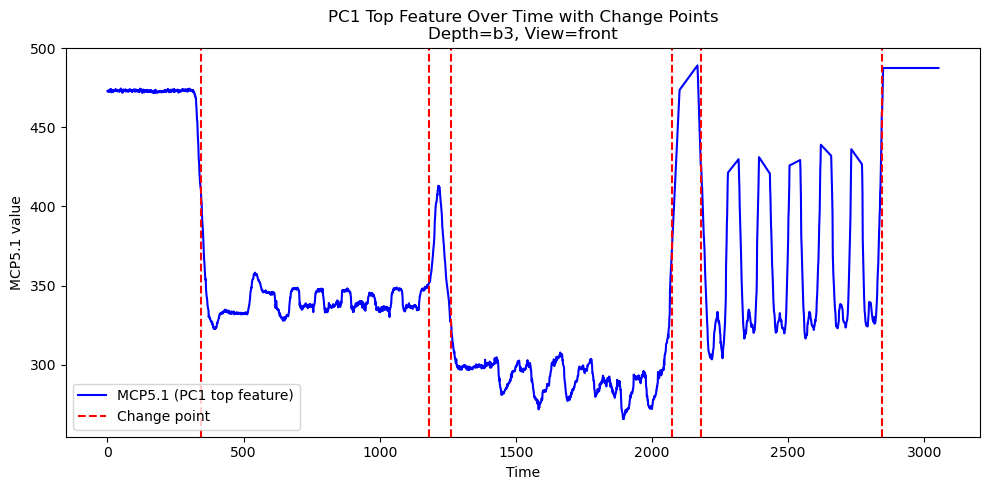

Change points (frame indices) for b3 front: [345, 1180, 1260, 2075, 2180, 2845, 3053]

Processing depth=b3, view=side


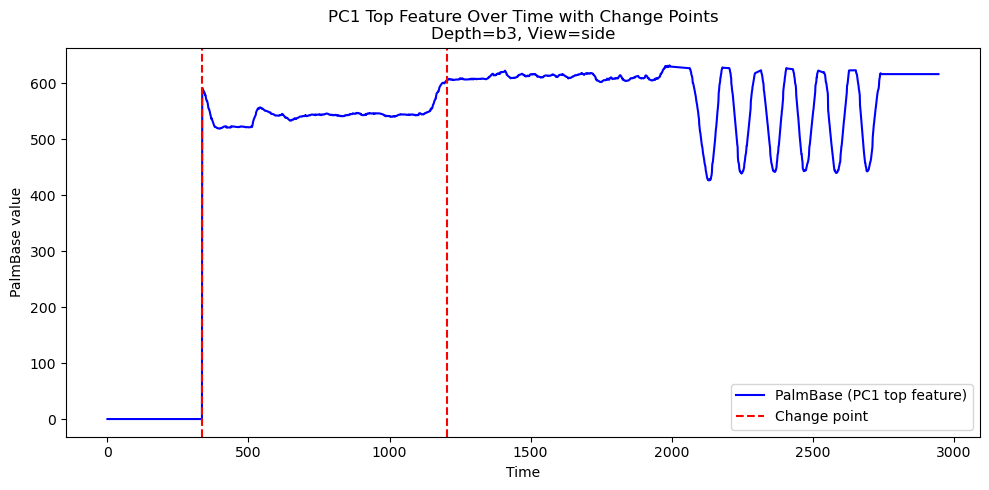

Change points (frame indices) for b3 side: [335, 1205, 2947]

Processing depth=c2, view=front


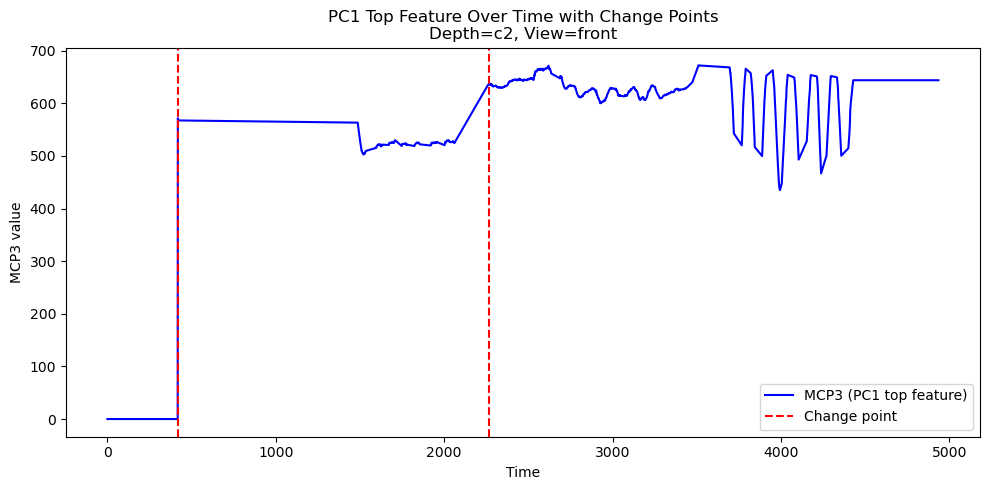

Change points (frame indices) for c2 front: [420, 2265, 4936]

Processing depth=c2, view=side


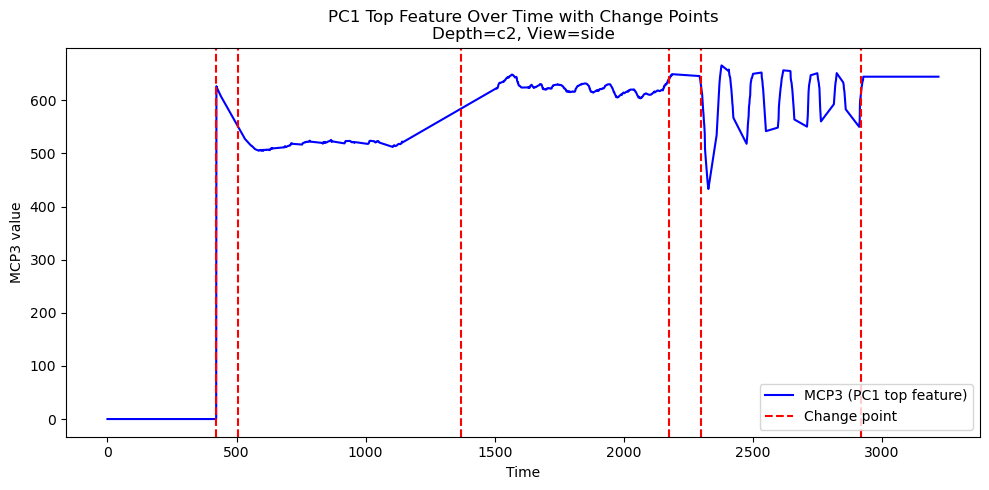

Change points (frame indices) for c2 side: [420, 505, 1370, 2175, 2300, 2920, 3219]

Processing depth=c1, view=front
Skipping c1 front - missing top features

Processing depth=c1, view=side


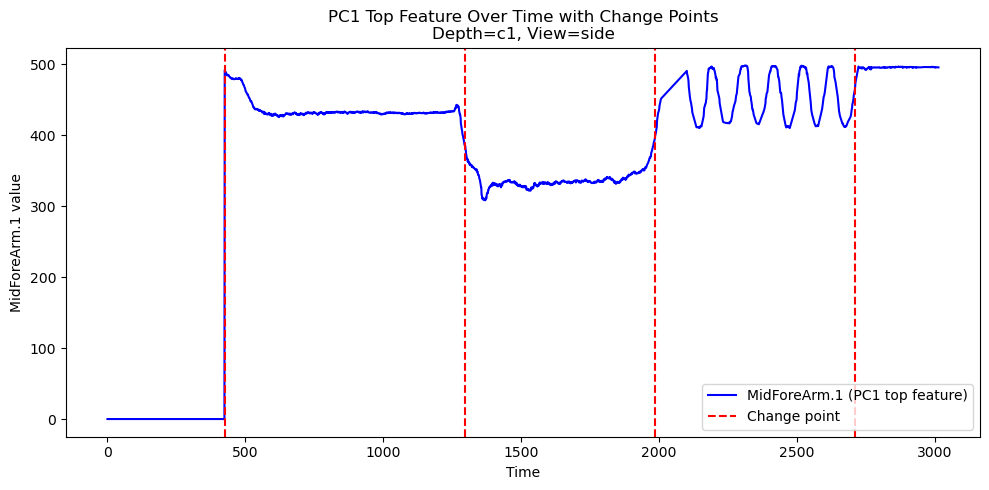

Change points (frame indices) for c1 side: [425, 1295, 1985, 2710, 3013]

Processing depth=c3, view=front


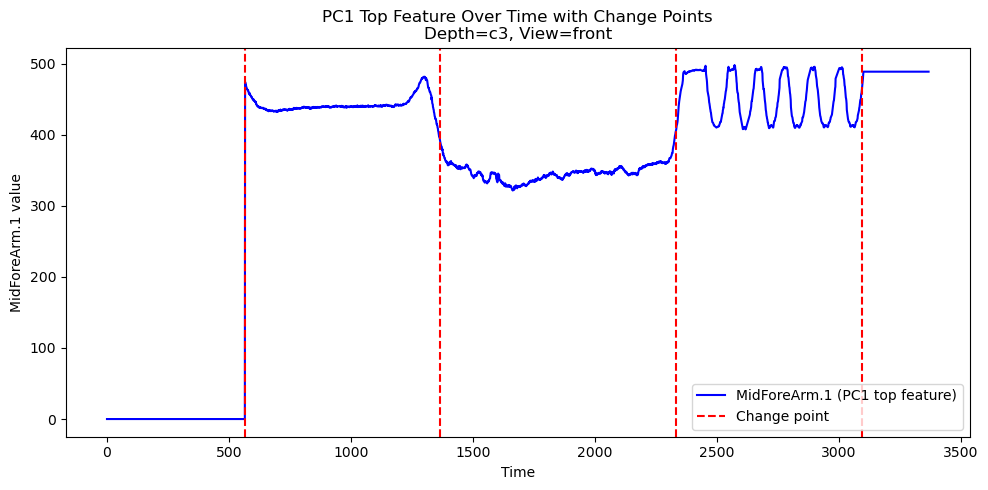

Change points (frame indices) for c3 front: [565, 1365, 2330, 3095, 3368]

Processing depth=c3, view=side


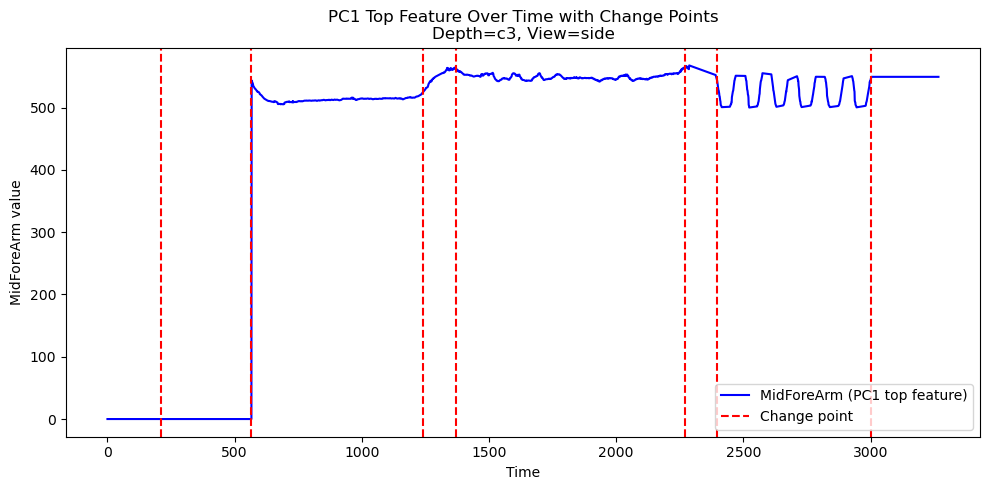

Change points (frame indices) for c3 side: [210, 565, 1240, 1370, 2270, 2395, 3000, 3268]

Processing depth=t1, view=front


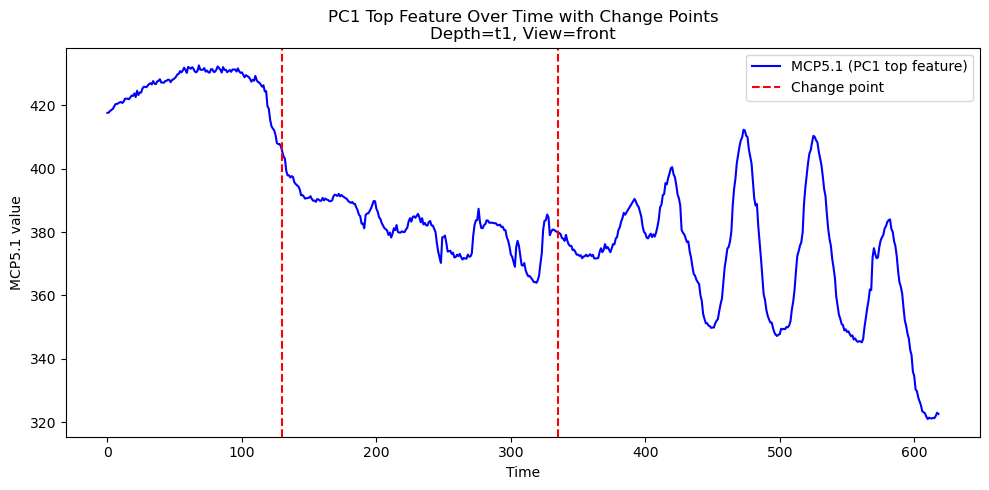

Change points (frame indices) for t1 front: [130, 335, 619]

Processing depth=t1, view=side


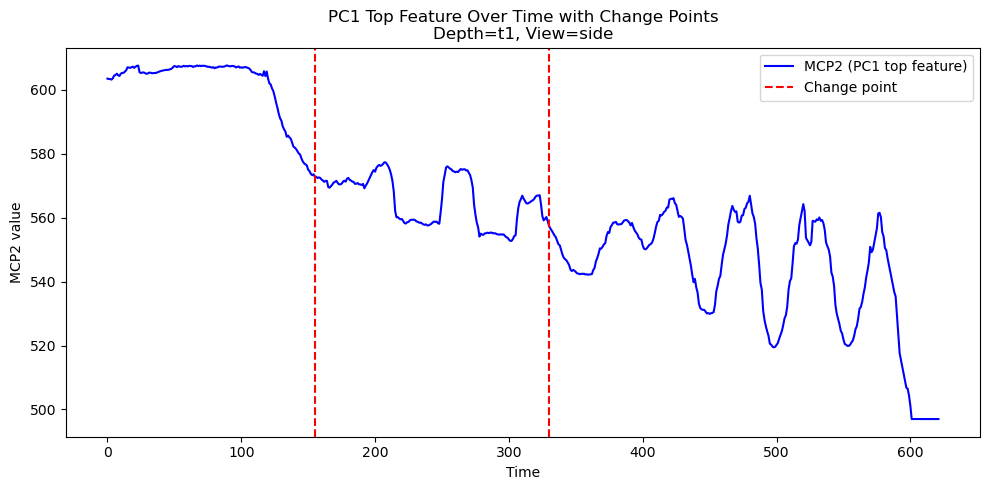

Change points (frame indices) for t1 side: [155, 330, 622]

Processing depth=t2, view=front


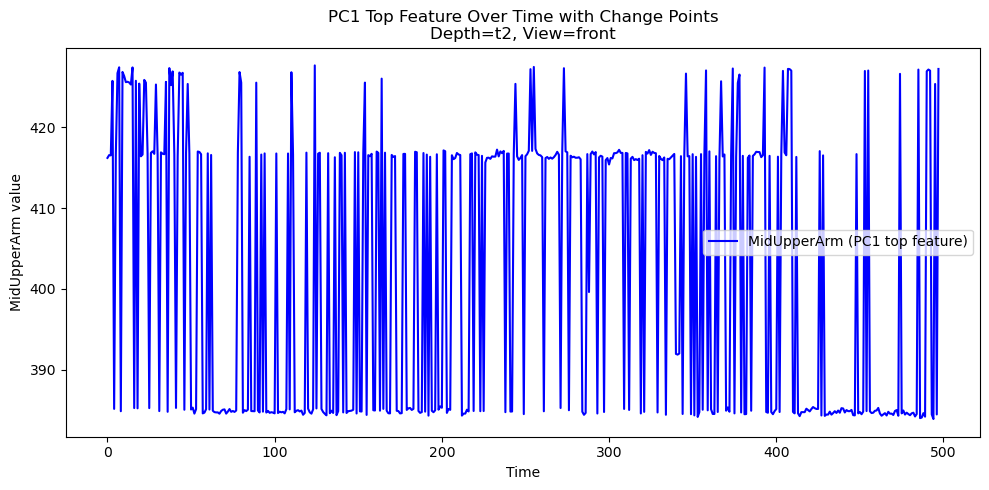

Change points (frame indices) for t2 front: [498]

Processing depth=t2, view=side


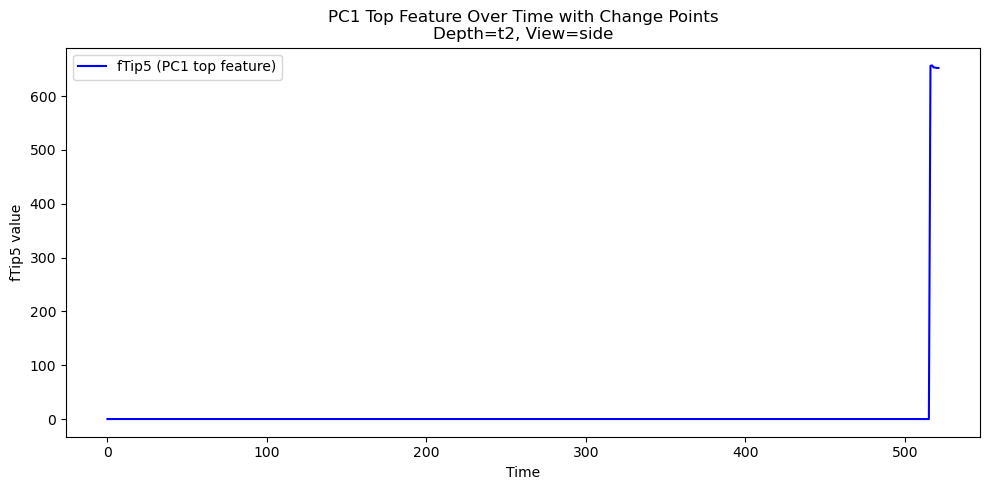

Change points (frame indices) for t2 side: [522]

Processing depth=t3, view=front


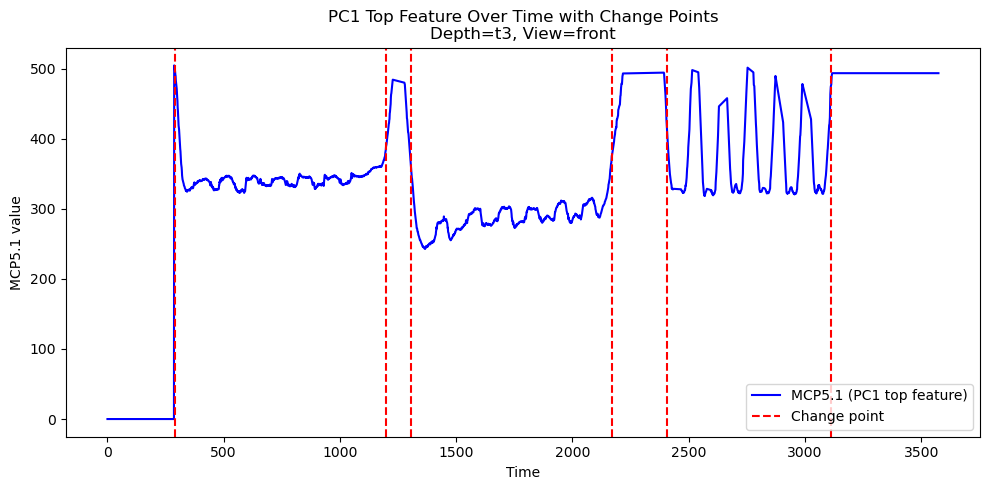

Change points (frame indices) for t3 front: [290, 1200, 1305, 2170, 2405, 3110, 3575]

Processing depth=t3, view=side


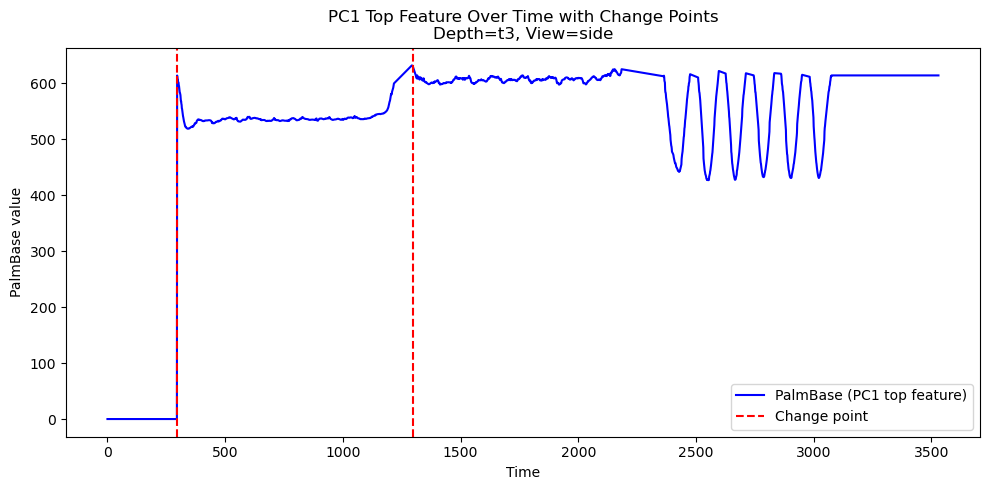

Change points (frame indices) for t3 side: [295, 1300, 3531]


In [22]:
results_list = []

# Parameters for ruptures
model = "rbf"
penalty_value = 30  # Adjust as needed

for depth in depths:
    for view in views:
        print(f"\nProcessing depth={depth}, view={view}")

        # Get top PC1 and PC2 features
        top_feature_pc1 = get_top_feature(top5_pc1_df, depth, view, 'PC1')
        top_feature_pc2 = get_top_feature(top5_pc2_df, depth, view, 'PC2')

        if top_feature_pc1 is None or top_feature_pc2 is None:
            print(f"Skipping {depth} {view} - missing top features")
            continue

        df_key = depth + ('f' if view == 'front' else 's')
        if df_key not in dataframes:
            print(f"Data for {df_key} not found in dataframes.")
            continue

        df = dataframes[df_key]

        if top_feature_pc1 not in df.columns or top_feature_pc2 not in df.columns:
            print(f"Features {top_feature_pc1} or {top_feature_pc2} not found in dataframe for {df_key}")
            continue

        # Extract data
        x = df[top_feature_pc1].to_numpy()
        y = df[top_feature_pc2].to_numpy()
        t = np.arange(len(x))

        # Stack for ruptures input
        signal = np.column_stack((x, y))  # shape (n_samples, 2)

        # Run RBF change point detection
        algo = rpt.Pelt(model=model).fit(signal)
        change_points = algo.predict(pen=penalty_value)



        # Inside the nested loop after change_points are computed
        plt.figure(figsize=(10, 5))
        plt.plot(t, x, label=f"{top_feature_pc1} (PC1 top feature)", color='blue')
        for cp in change_points[:-1]:  # Skip the last point if it's just the end of signal
            plt.axvline(x=cp, color='red', linestyle='--', label='Change point' if cp == change_points[0] else "")
        plt.xlabel("Time")
        plt.ylabel(f"{top_feature_pc1} value")
        plt.title(f"PC1 Top Feature Over Time with Change Points\nDepth={depth}, View={view}")
        plt.legend()
        plt.tight_layout()
        plt.show()




        # Print results
        print(f"Change points (frame indices) for {depth} {view}: {change_points}")

        # Create a dictionary for storing change point results
        dic_indices = {
            "depth": depth,
            "view": view,
            "component": "indices"
        }

        # Save the top features and their change points
        dic_indices["feature_1"] = top_feature_pc1
        dic_indices["feature_2"] = top_feature_pc2
        dic_indices["change_points"] = change_points

        # Assuming you're collecting multiple such dictionaries into a list
        results_list.append(dic_indices)





In [23]:
df_indices = pd.DataFrame(results_list)

df_indices 

depth   view component     feature_1      feature_2  \
0     b1  front   indices          MCP4  MidUpperArm.1   
1     b1   side   indices          MCP2   MidForeArm.1   
2     b2  front   indices          MCP5   MidForeArm.1   
3     b2   side   indices          MCP3          Elbow   
4     b3  front   indices        MCP5.1           MCP4   
5     b3   side   indices      PalmBase          Elbow   
6     c2  front   indices          MCP3          Elbow   
7     c2   side   indices          MCP3         MCP1.1   
8     c1   side   indices  MidForeArm.1        Elbow.1   
9     c3  front   indices  MidForeArm.1        Elbow.1   
10    c3   side   indices    MidForeArm        fTip2.1   
11    t1  front   indices        MCP5.1          fTip5   
12    t1   side   indices          MCP2    MidUpperArm   
13    t2  front   indices   MidUpperArm  MidUpperArm.1   
14    t2   side   indices         fTip5           MCP4   
15    t3  front   indices        MCP5.1   MidForeArm.1   
16    t3   side   indices      PalmBase          Elbow   

                                     change_points  
0                   [1730, 2495, 3220, 4000, 4258]  
1                    [395, 1975, 2780, 3515, 4556]  
2              [380, 1325, 2165, 2265, 2955, 3271]  
3                                [395, 1325, 3223]  
4        [345, 1180, 1260, 2075, 2180, 2845, 3053]  
5                                [335, 1205, 2947]  
6                                [420, 2265, 4936]  
7         [420, 505, 1370, 2175, 2300, 2920, 3219]  
8                    [425, 1295, 1985, 2710, 3013]  
9                    [565, 1365, 2330, 3095, 3368]  
10  [210, 565, 1240, 1370, 2270, 2395, 3000, 3268]  
11                                 [130, 335, 619]  
12                                 [155, 330, 622]  
13                                           [498]  
14                                           [522]  
15       [290, 1200, 1305, 2170, 2405, 3110, 3575]  
16                               [295, 1300, 3531]

## Starting to build the df_movement

In [27]:
df_movements = pd.DataFrame(columns=['dataset', 'view', 'movement', 'indices'])

for _, row in df_indices.iterrows():
    all_indices = row['change_points']
    movement = 'arm_EF'

    if len(all_indices) == 1:
        continue

    if np.std([all_indices[-2], all_indices[-1]]) < 0.5:
        
        if all_indices[-3] - all_indices[-2] > 250:
            start = all_indices[-3]
            end = all_indices[-2]
        else:
            start = all_indices[-4]
            end = all_indices[-2]


    if all_indices[-2] - all_indices[-1] > 250:
        start = all_indices[-2]
        end = all_indices[-1]
    else:
        start = all_indices[-3]
        end = all_indices[-1]

    df_movements = pd.concat([
        df_movements,
        pd.DataFrame([{
            'dataset': row['depth'],        # <- use `row` to access data from df_indices
            'view': row['view'],
            'movement': movement,
            'indices': (start, end)
        }])
    ], ignore_index=True)


In [25]:
df_movements

dataset   view movement       indices
0       b1  front   arm_EF  (3220, 4258)
1       b1   side   arm_EF  (2780, 4556)
2       b2  front   arm_EF  (2265, 3271)
3       b2   side   arm_EF   (395, 3223)
4       b3  front   arm_EF  (2180, 3053)
5       b3   side   arm_EF   (335, 2947)
6       c2  front   arm_EF   (420, 4936)
7       c2   side   arm_EF  (2300, 3219)
8       c1   side   arm_EF  (1985, 3013)
9       c3  front   arm_EF  (2330, 3368)
10      c3   side   arm_EF  (2395, 3268)
11      t1  front   arm_EF    (130, 619)
12      t1   side   arm_EF    (155, 622)
13      t3  front   arm_EF  (2405, 3575)
14      t3   side   arm_EF   (295, 3531)

## Matching code

In [ ]:
import numpy as np

# Two example lists of (possibly unequal) length
list_a = [50, 120, 200]
list_b = [48, 190]

# Define what "close" means
threshold = 5

# Compare each element in list_a to all elements in list_b
matches = []
for a in list_a:
    if any(abs(a - b) <= threshold for b in list_b):
        matches.append((a, True))   # a is close to some b
    else:
        matches.append((a, False))  # a is not close to any b

print(matches)


## THIS COMPARES TWO FULL PCS!!! MIGHT BE HELPFUL

In [ ]:
results_list2 = []

# Parameters for ruptures
model = "rbf"
penalty_value = 30  # Adjust as needed

for depth in depths:
    for view in views:
        print(f"\nProcessing depth={depth}, view={view}")

        view_letter = 'f' if view == 'front' else 's'
        df_key = depth + view_letter

        if df_key not in dataframes:
            print(f"Data for {df_key} not found in dataframes.")
            continue

        pca_key = (depth, view)
        if pca_key not in pca_transformed:
            print(f"PCA data for {pca_key} not found.")
            continue

        pca_df = pca_transformed[pca_key]

        if 'PC1' not in pca_df.columns or 'PC2' not in pca_df.columns:
            print(f"'PC1' or 'PC2' not found in PCA data for {pca_key}")
            continue

        # Extract PC1 and PC2 time series
        x = pca_df['PC1'].to_numpy()
        y = pca_df['PC2'].to_numpy()
        t = np.arange(len(x))

        # Stack for ruptures input
        signal = np.column_stack((x, y))  # shape (n_samples, 2)

        # Run RBF change point detection
        algo = rpt.Pelt(model=model).fit(signal)
        change_points = algo.predict(pen=penalty_value)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(t, x, label='PC1', color='blue')
        for cp in change_points[:-1]:  # Skip last if it's just end of signal
            plt.axvline(x=cp, color='red', linestyle='--', label='Change point' if cp == change_points[0] else "")
        plt.xlabel("Time")
        plt.ylabel("PC1 Value")
        plt.title(f"PC1 Over Time with Change Points\nDepth={depth}, View={view}")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Save results
        dic_indices = {
            "depth": depth,
            "view": view,
            "component": "PCs",
            "feature_1": "PC1",
            "feature_2": "PC2",
            "change_points": change_points
        }

        results_list2.append(dic_indices)
